<a href="https://colab.research.google.com/github/DeeperSense/BTS-2023/blob/master/sonavision/sonavision-bts-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
!curl https://cloud.dfki.de/owncloud/index.php/s/jyTsJfSR6fCjMoR/download --output data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1074M    0 1074M    0     0  12.8M      0 --:--:--  0:01:23 --:--:-- 15.9M
Archive:  data.zip
   creating: BTS23/
   creating: BTS23/indoor-pool/
   creating: BTS23/indoor-pool/models/
   creating: BTS23/indoor-pool/models/assets/
 extracting: BTS23/indoor-pool/models/saved_model.pb  
   creating: BTS23/indoor-pool/models/variables/
 extracting: BTS23/indoor-pool/models/variables/variables.data-00000-of-00001  
 extracting: BTS23/indoor-pool/models/variables/variables.index  
   creating: BTS23/indoor-pool/test-data/
 extracting: BTS23/indoor-pool/test-data/0-0516.png  
 extracting: BTS23/indoor-pool/test-data/0-0945.png  
 extracting: BTS23/indoor-pool/test-data/0-1713.png  
 extracting: BTS23/indoor-pool/test-data/100-0516.png  
 extracting: BTS23/indoor-pool/test-data/100-0945.png  
 extracting: BTS23/indoor-pool/test-data/

In [6]:
dataset = "lake-cropped"
model_dir = "/content/BTS23/{}/models".format(dataset)
generator = tf.keras.models.load_model(model_dir)
generator.compile()

In [7]:
image_file = "/content/BTS23/{}/test-data/0-00000139.png".format(dataset)
image = tf.io.read_file(image_file)
if image_file[-3:]=="png":
  image = tf.io.decode_png(image)
elif image_file[-3:]=="jpg":
  image = tf.io.decode_jpeg(image)

In [8]:
def normalize_inputs(x):
    normalized = []
    for img in x:
        normalized.append((img / 127.5) - 1)
    return normalized

w = tf.shape(image)[1] // 3
images =[]
for i in range(3):
    images.append(tf.cast(image[:, i * w : (i + 1) * w, :], tf.float32))

camera = images[0]
sonar = images[2]
d = 0.75
night = (1-d)*camera
#night = camera

var = 10 * d
k = int(np.ceil(100 * d*2) // 2 * 2 + 1)
kernel = (k,k)
night = cv2.GaussianBlur(src=night.numpy(), ksize=kernel, sigmaX=var, sigmaY=var)  # gaussian blur



images = normalize_inputs([camera, night, sonar])
camera, night, sonar = images

In [9]:
prediction = generator([night[None,:,:,:], sonar[None,:,:,:]], training=True)

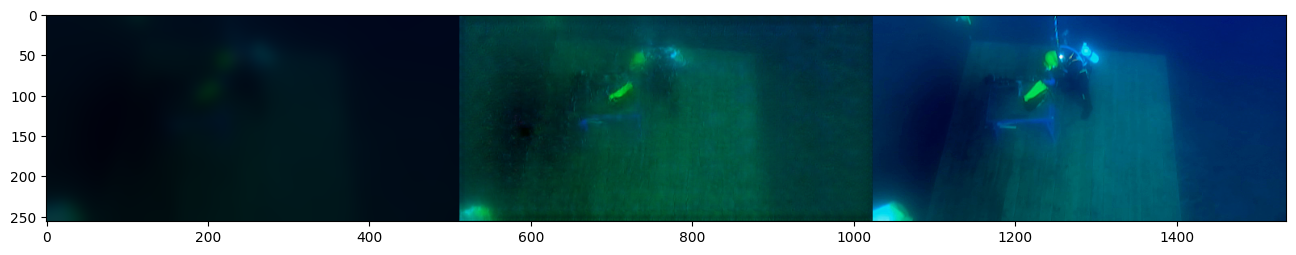

In [10]:
pred = prediction[0].numpy()
stacked = np.hstack((night,pred,camera))
plt.figure(figsize=(16,5))
plt.imshow(stacked*0.5+0.5)